# ***Tarea 9.KMeans & Shap***
### Luis Eduardo Jiménez del Muro - 01/05/2025
---

# *Paqueterías*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import shap

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', '{:,.4f}'.format)

plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['figure.facecolor'] = 'lightgray'

c:\Users\epile\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# *Funciones*

In [2]:
"""
Grafica de calibración
--------------------------------------------------------------------------------------------------------
"""
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
    grouped = df_calibracion.groupby('bins').mean()
    auc = roc_auc_score(y_score=predicciones, y_true=y)
    
    # Gráfica
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=5, lw=2)
    plt.title(f'Calibración del modelo \n\n$AUC={auc:.4f}$', fontsize=16, fontweight='bold')
    plt.grid(alpha=0.3, ls='--')
    plt.legend(fontsize=12, loc='best')
    plt.show()


"""
Roc Curve
--------------------------------------------------------------------------------------------------------
"""
def roc_curve_graph(probabilidades, y):
    fpr, fpn, scores = roc_curve(y_score=probabilidades, y_true=y)

    plt.title('ROC Curve', fontsize=16, fontweight='bold')
    plt.plot(fpr, fpn, label='Modelo', color='cadetblue', lw=2)
    plt.plot([0, 1], [0, 1], label='Real', color='red', lw=1.5)
    plt.xlabel("1-specificty")
    plt.ylabel("sensitivity")
    plt.legend(loc='best')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


"""
Histograma de probabilidades
--------------------------------------------------------------------------------------------------------
"""
def histograma(probabilidades, y):
    resultados = pd.DataFrame({'y':y, 'probabilidades': probabilidades})

    sns.histplot(resultados[resultados['y'] == 0]['probabilidades'], stat='density', 
                 color='seagreen', alpha=0.40, kde=True, bins=20, edgecolor=None, label='0')
    sns.histplot(resultados[resultados['y'] == 1]['probabilidades'], stat='density', 
                 color='cadetblue', alpha=0.65, kde=True, bins=20, edgecolor=None, label='1')
    plt.title('Histograma de probabilidades', fontsize=16, fontweight='bold')
    plt.legend(loc='best')
    plt.xlabel('Probabilidades')
    plt.ylabel('Frecuencia')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


"""
Importance Plot
--------------------------------------------------------------------------------------------------------
"""
def importance_plot(features, importance, type, n_features=10):
    df_importancia = pd.DataFrame({
        'features': features, 
        'importance': importance}).sort_values(by='importance', ascending=True)
    
    plt.barh(df_importancia['features'].tail(n_features), df_importancia['importance'].tail(n_features), 
             color='cadetblue', zorder=2, height=0.4)
    for i, v in enumerate(df_importancia['importance'].tail(n_features)):
        plt.text(v, i, f'{v:.4f}', color='black', fontsize=10)
    plt.title(f'{type}', fontweight='bold', fontsize=16)
    plt.grid(alpha=0.5, ls='--', axis='x', zorder=0)
    plt.show()


"""
Plot Resultados
--------------------------------------------------------------------------------------------------------
"""
def plot_results(probabilidades, y, bins):
    calibracion(probabilidades, y, bins)
    histograma(probabilidades, y)
    roc_curve_graph(probabilidades, y)


"""
Funciones para el análisis de clusters
--------------------------------------------------------------------------------------------------------
"""
def subplots(data, type):
    grouped_data = getattr(data.groupby('Cluster'), type)()

    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten() 

    for i, column in enumerate(grouped_data.columns):
        axes[i].bar(grouped_data.index, grouped_data[column], color='cadetblue')
        axes[i].set_title(column)
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(f'{type.capitalize()}')
        axes[i].set_xticks(grouped_data.index)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    for ax in axes:
        ax.grid(alpha=0.3, linestyle='--', axis='y')
        
    plt.suptitle(f'Cluster Analysis | ({type.capitalize()})', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 1]) 
    plt.show()


In [3]:
"""
Ajuste de XGBoost
--------------------------------------------------------------------------------------------------------
"""
def xgboost(X_train, y_train, X_test, y_test):
    params = {
        'n_estimators': [100_000],
        'max_depth': [1, 2, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'reg_lambda': [0.01, 0.1, 1],
        'tree_method': ['hist'],
        'eval_metric': ['auc']
    }

    model = XGBClassifier(eval_metric='auc', n_jobs=-1, random_state=42,early_stopping_rounds=20)

    xgb_grid = GridSearchCV(estimator=model, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params)
    xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

    best_model = xgb_grid.best_estimator_
    predicciones = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predicciones)

    weight = best_model.get_booster().get_score(importance_type='weight')
    gain = best_model.get_booster().get_score(importance_type='gain')

    print(f'Best parameters:')
    display(xgb_grid.best_params_)
    return best_model, predicciones, auc, weight, gain


"""
Método del Codo
--------------------------------------------------------------------------------------------------------
"""
def elbow_method(data, max_clusers=11):
    inertias = []

    # ¿Cuantos clusters probar?
    K_range = range(1, max_clusers)

    for i in K_range:
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=i, random_state=42))
        ])
        pipeline.fit(data)
        inertias.append(pipeline.named_steps['kmeans'].inertia_)

    plt.figure()
    plt.plot(K_range, inertias, marker='o', linestyle='--', color='cadetblue')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.grid(alpha=0.5, ls='--')
    plt.show()


"""
Clusterización
--------------------------------------------------------------------------------------------------------
"""
def cluster(X, n_clusters):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
    ])
    pipeline.fit(X)
    return pipeline.named_steps['kmeans'].labels_ + 1

# *Preparar los datos*

In [4]:
data = pd.read_csv('data/titanic.csv')
data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
data = pd.get_dummies(data)
data = data.drop(columns=['Sex_female'])
data = data.fillna(data.mean())
target = 'Survived'

X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# *XGBoost*

Best parameters:


{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 100000,
 'reg_lambda': 0.01,
 'tree_method': 'hist'}

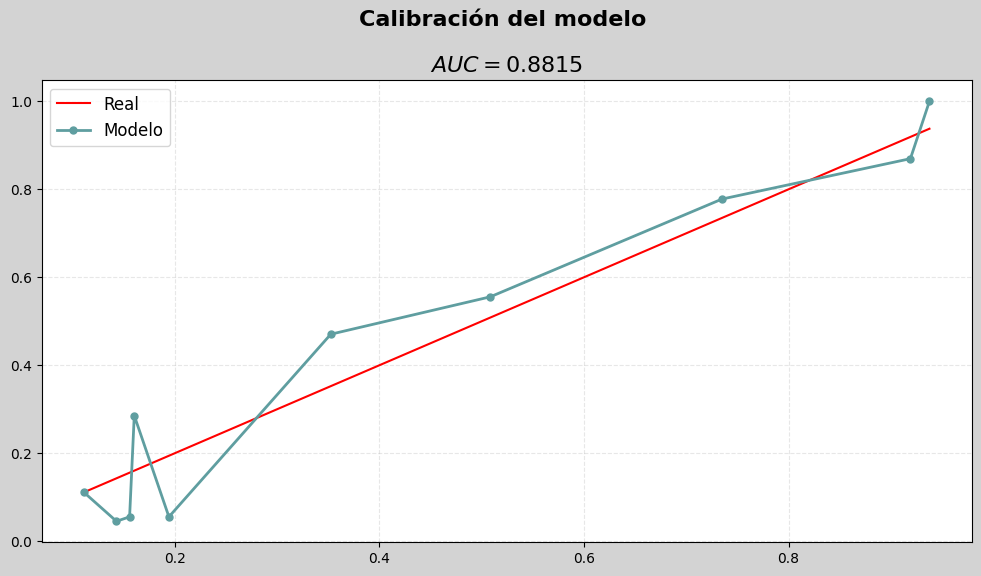

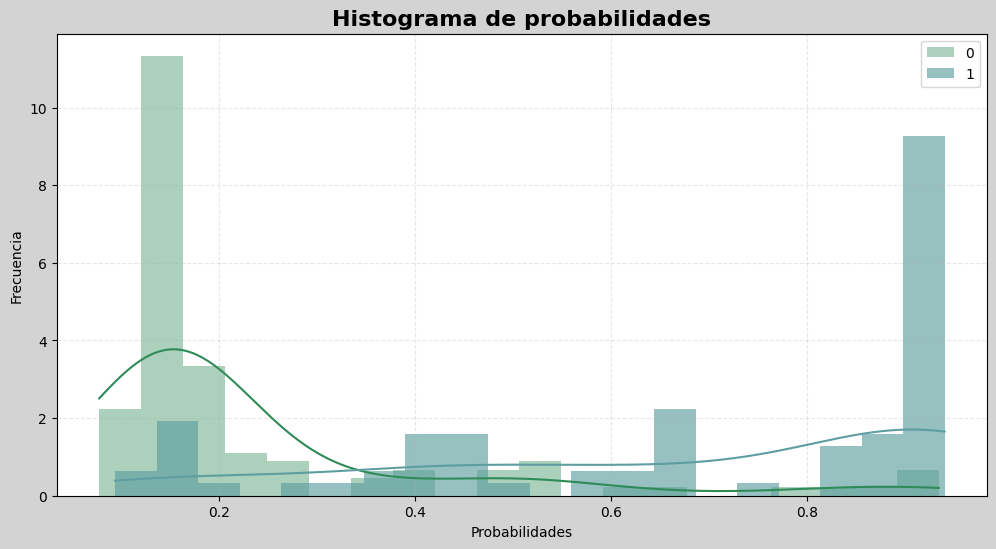

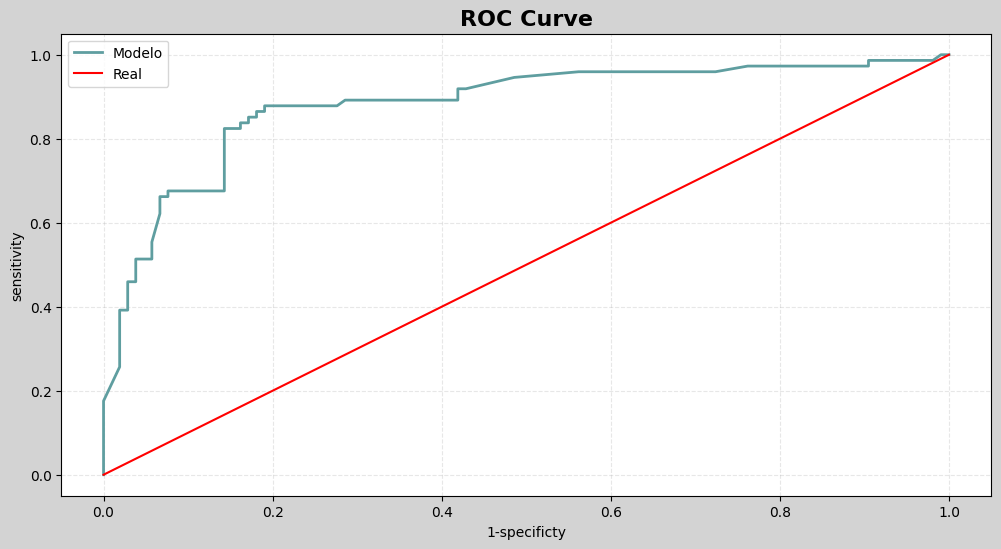

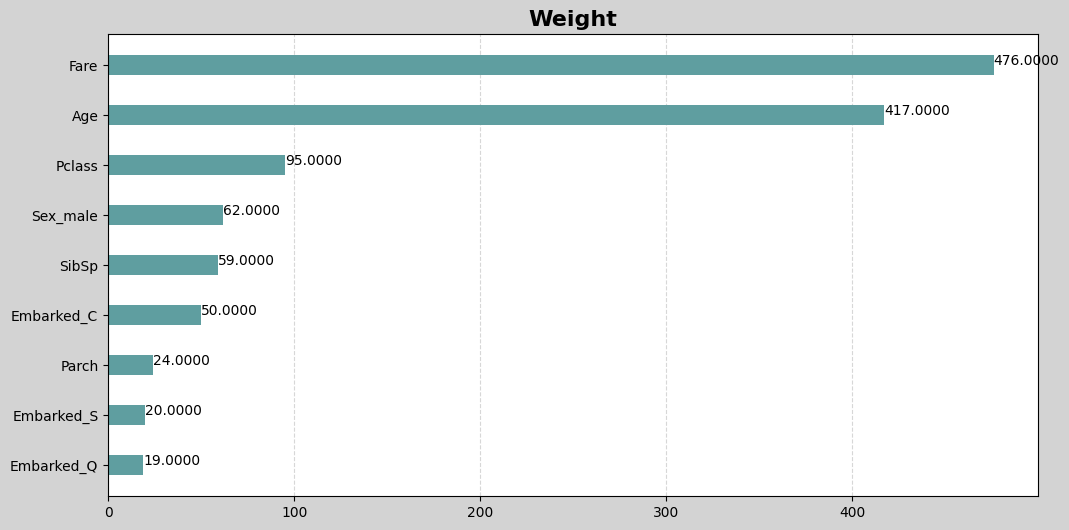

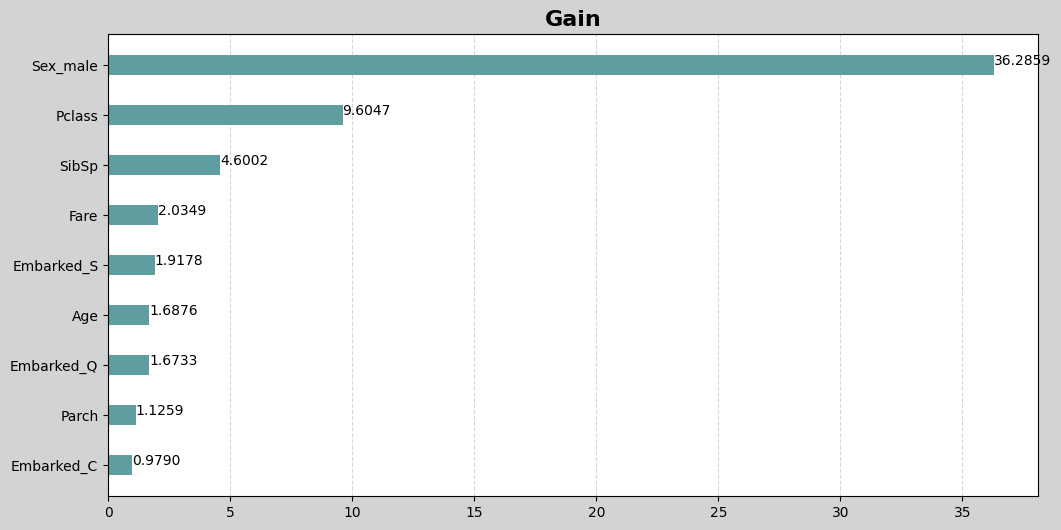

In [5]:
model, predicciones, auc, weight, gain = xgboost(X_train, y_train, X_test, y_test)
plot_results(predicciones, y_test, bins=10)
importance_plot(X_train.columns, weight.values(), 'Weight')
importance_plot(X_train.columns, gain.values(), 'Gain')

Muy buen modelo con AUC 0.88. En el histograma de probabilidades podemos observar la el excelente poder de clasificación que tiene, distinguiendo muy bien entre los que sobrevivieron y no sobrevivieron. La curva roc tiene un area muy amplia, y en general, las variables más importantes fueron: `Fare`, `Age`, `Sex_male` y `Pclass`.

# *Shap values para una predicción en el conjunto de prueba*

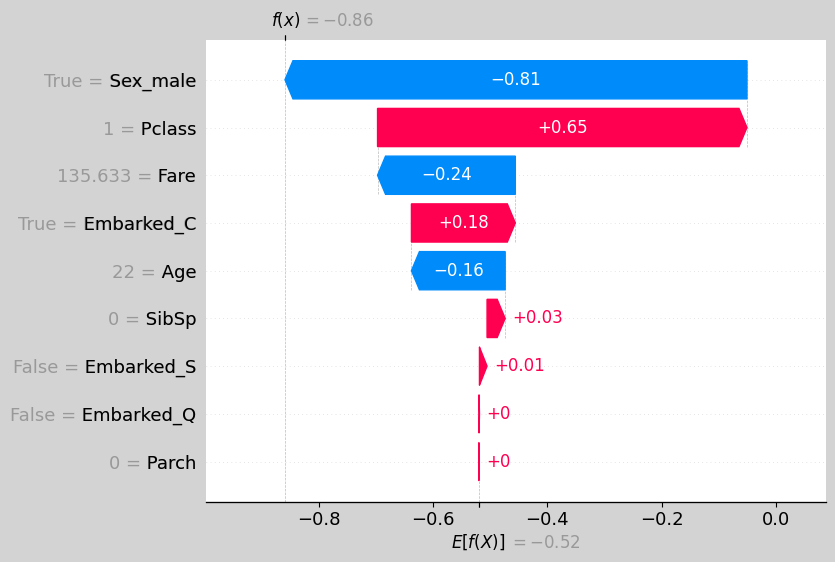

In [20]:
X_shap = X_train.copy()
X_shap = X_train.sample(100, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.initjs()
plt.figure()
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0], 
    base_values=explainer.expected_value, 
    data=X_shap.iloc[0], 
    feature_names=X_shap.keys()
))

Según el modelo, este pasajero tiene pocas probabilidades de sobrevivir, pues su predicción es menor al promedio. Principalmente, observamos que el hecho de ser hombre redujo muchísimo sus probabilidades. Por otro lado, vemos que esto se contrarresta mucho dado que viajaba en primera clase. Su alto costo de tarifa y edad joven, tambien reducen la probabilidad de sobrevivir, mientras que haber abordado en C le aumenta un poco. Con esto concluimos que lo más probable es que este pasajero no haya sobrevivido.

# *Shap values generales*

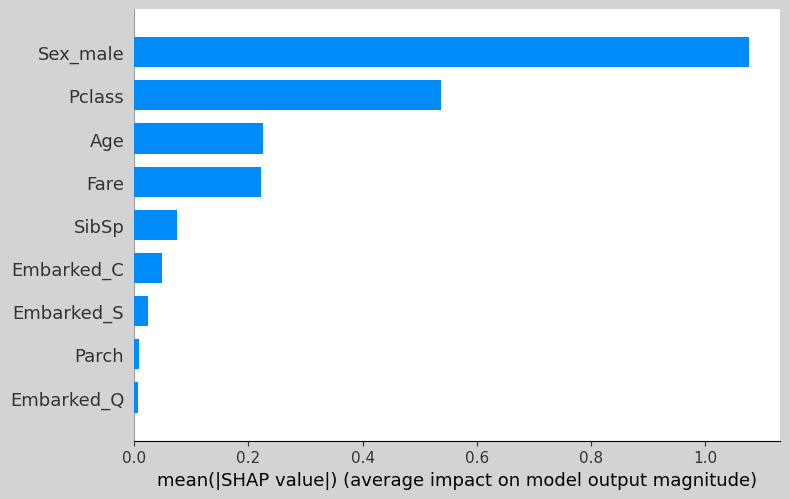

In [23]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

Observamos que la variable más importante, con bastante diferencia, que define si sobrevive o no un pasajero es si era hombre o mujer. Además hay otras variables que tienen impacto en la predicción, como la clase en la que viajaba el pasajero, su edad, y su tarifa. Las demás variables son casi irrelevantes a comparación del impacto promeido que tienen las demás variables sobre el objetivo.

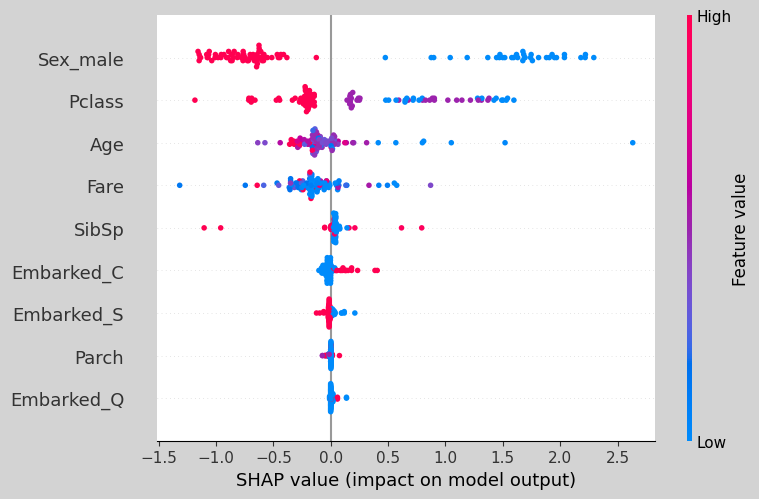

In [8]:
shap.summary_plot(shap_values, X_shap, plot_type='dot', max_display=10)

+ Nuevamente observamos que el sexo es la más importante en el modelo. Vemos que si el valor de sex_male es alto/rojo(entonces es hombre) disminuye el shap value y por ende su probabilidad. Si el valor es bajo/azul (entonces es mujer) sube mucho su shap value. 

+ Observamos la misma división en la clase de los pasajeros. A medida que sube la clase (es decir peor clase) disminuye el shap value y por ende la probabilidad de supervivencia. Pasajeros con clase baja tienen mayor shap value.

+ En las demás variables no se observan separaciones igual de importantes que en las anteriores 2.

# *KMeans y Método del codo, ¿cuántos clusters?*

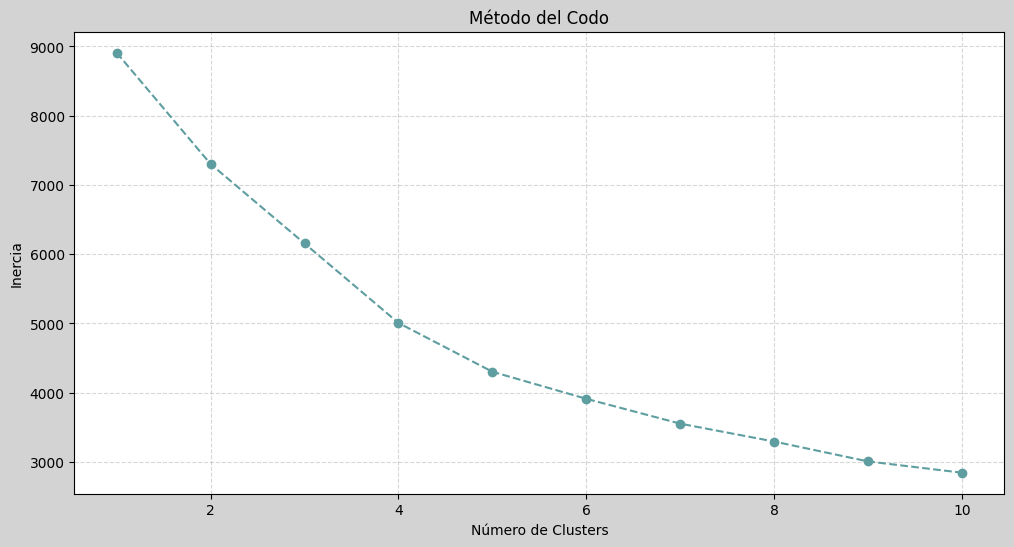

In [9]:
elbow_method(data)

Gracias al método del codo, podemos identificar que el número óptimo de clusters es de 4, debido a que se aprcia un quiebre y disminuye la pendiente de la curva en ese punto.

In [10]:
clusters = cluster(data, n_clusters=4)
data['Cluster'] = clusters
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cluster
0,0,3,22.0000,1,0,7.2500,True,False,False,True,2
1,1,1,38.0000,1,0,71.2833,False,True,False,False,3
2,1,3,26.0000,0,0,7.9250,False,False,False,True,1
3,1,1,35.0000,1,0,53.1000,False,False,False,True,1
4,0,3,35.0000,0,0,8.0500,True,False,False,True,2


# *Características del cluster*

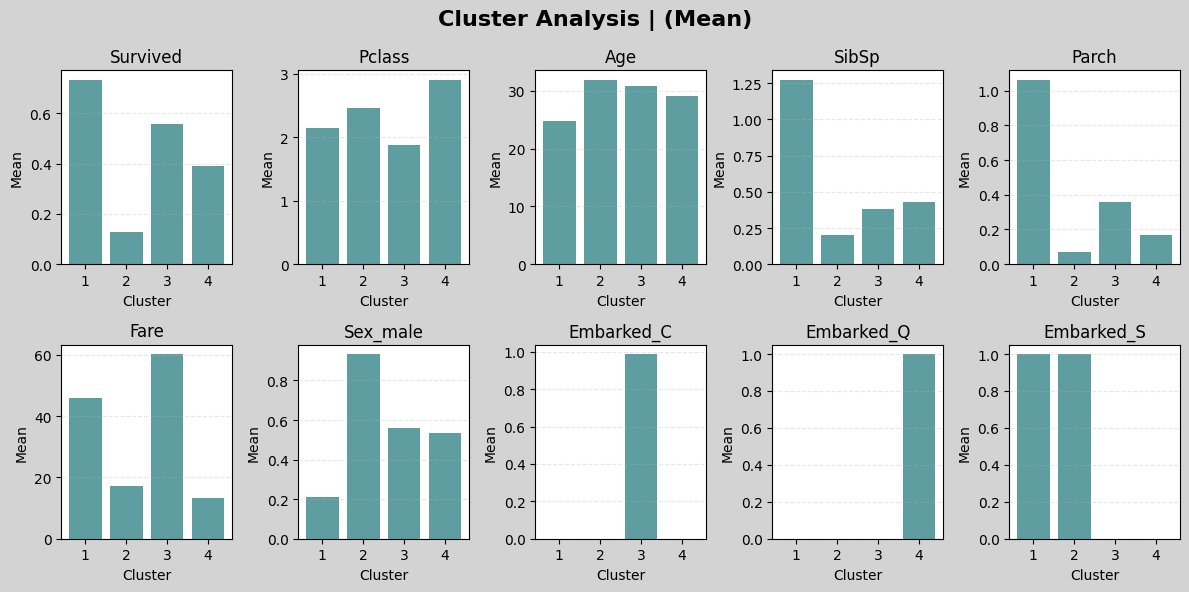

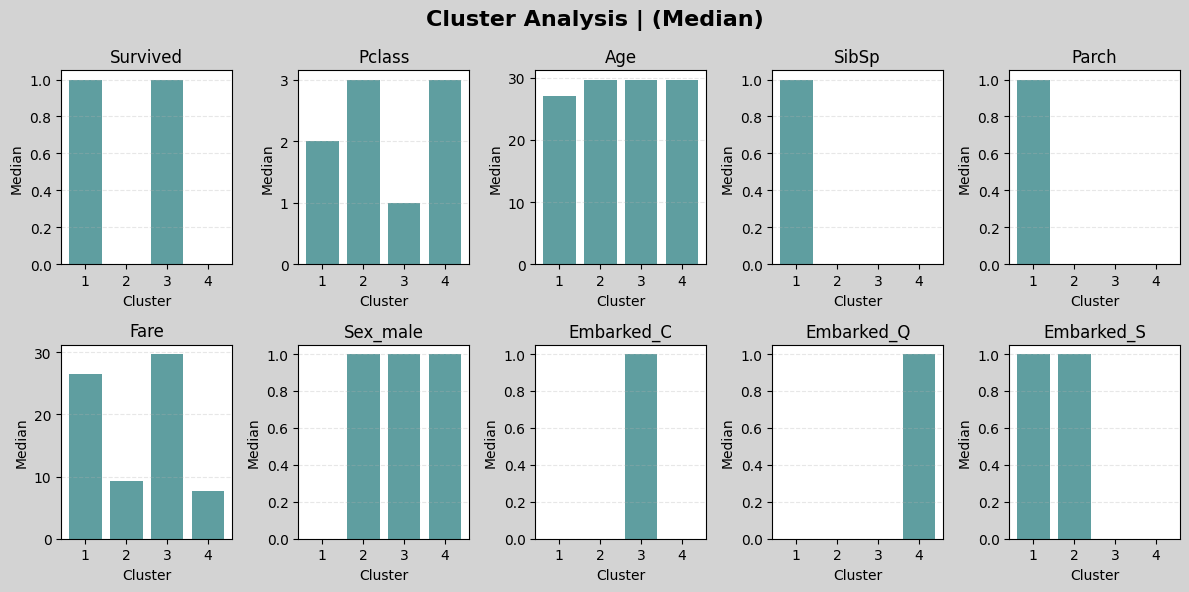

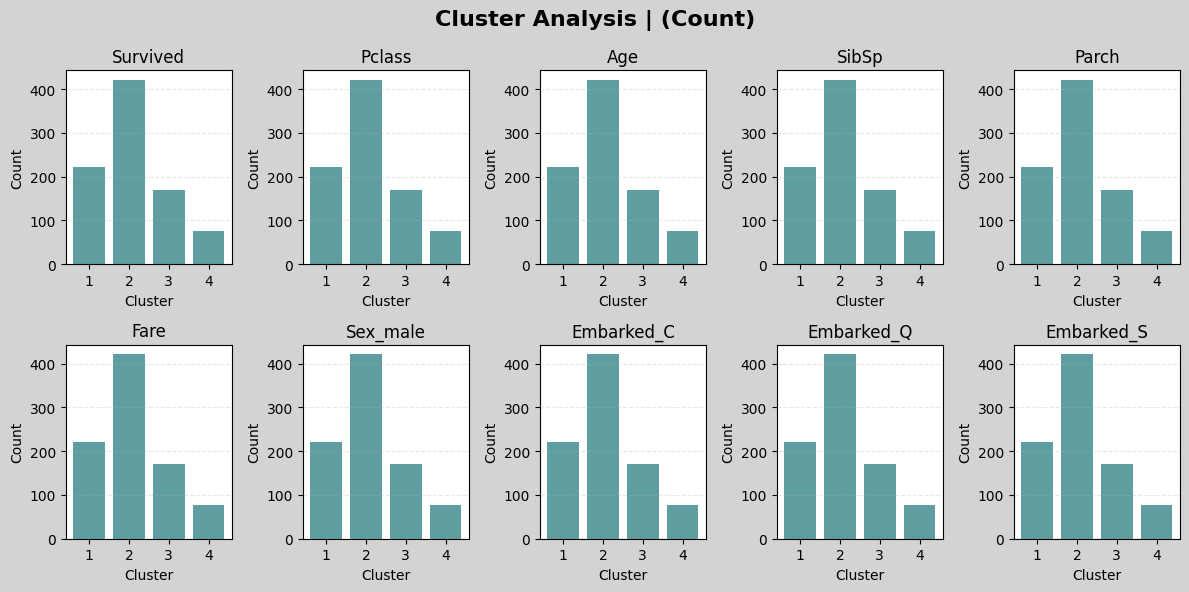

In [15]:
types = ['mean', 'median', 'count']

for type in types:
    subplots(data, type)


### Cluster 1:
- Edad mas baja en promedio.
- La probabilidad de supervivencia más alta.
- Tarifa (Fare) promedio moderadamente alta.
- Pclass en promedio de 2.
- Cluster mayormente de mujeres.
- Todos abordaron en S.
- Segundo cluster con mayor cantidad de datos
- Grupo con el mayroor numero de familiares a bordo (SibsSp, Parch)

### Cluster 2:
- Edad más alta en promedio
- Probabilidad de supervivencia más baja de todos los grupos.
- Tarifa muy baja.
- Mayormente grupo de hombres.
- Pclass promedio poco por encima de 2
- Abordaron en S.
- Cluster con mayor cantidad de datos, con más del doble que los demás.
- Grupo con la menor cantidad de familiares a bordo.

### Cluster 3:
- Probabilidad de supervivencia de alrededor de 0.5
- Pclass más bajo de todos lops clusters
- Segundo grupo con edad promedio más alta
- Abordaron en C
- Grupo dividido de hombres y mujeres.
- Tarifa promedio más alta.
- Pocos familiares a bordo.

### Cluster 4:
- Menos de la mitad sobrevivieron.
- Grupo con menor cantidad de personas.
- Grupo con la tarifa promedio más baja.
- Pocos familiares a bordo.
- Abordaron en Q.
- Grupo dividido de hombres y mujeres.
- Pclass promedio de 3, el más alto de todos.
